Импортируем все необходимые библиотеки

In [2]:
#загружаем библиотеки для работы со структурированными данными, массивами и регулярными выражениями
import pandas as pd
import numpy as np
import re

#загружаем библиотеку для отображения времени выполнения ячейки и времени выполнения кода
import time

#загружаем библиотеку для корректной загрузки датасетов
import os
#загружаем библиотеку для проверки корректности url ссылки
import requests


#загружаем классы для визуализации
from matplotlib import pyplot as plt
import seaborn as sns

#загружаем библиотеку для корреляционного анализа
import phik

# загружаем класс pipeline
from sklearn.pipeline import Pipeline

# загружаем классы для подготовки данных
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer

# загружаем класс для работы с пропусками
from sklearn.impute import SimpleImputer

# загружаем нужные модели
from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.neighbors import KNeighborsRegressor

#загружаем инструменты для подбора гиперпараметров
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

# загружаем функции для работы с метриками
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import make_scorer

Объявляем также константы

In [3]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

## Загрузка и изучение данных

Загружаем файл датасета, создаем датафрейм, выводим первые 15 строк и основную информацию для ознакомления. Используем параметр `parse_dates` для того, чтобы сразу явно указать в `read_csv` столбцы, которые необходимо преобразовать во временной тип данных.

In [4]:
#проверяем существование указанной дирректории и в случае возврата True загружаем датасет в переменную, указав верные разделители
pth1 = '/datasets/autos.csv'
pth2 = 'https://...../autos.csv' #полная ссылка скрыта ввиду NDA
pth3 = 'autos.csv'
if os.path.exists(pth1):
    data_main = pd.read_csv(pth1, sep=',', decimal = '.', parse_dates = ['DateCrawled','DateCreated','LastSeen'])
#добавляем проверку корректности url ссылки при помощи requests.get(url) и проверки status_code == 200
elif requests.get(pth2).status_code == 200:
    data_main = pd.read_csv(pth2, sep=',', decimal = '.', parse_dates = ['DateCrawled','DateCreated','LastSeen'])
elif os.path.exists(pth3):
    data_main = pd.read_csv(pth3, sep=',', decimal = '.', parse_dates = ['DateCrawled','DateCreated','LastSeen'])
else:
    print('Something is wrong')


#выводим первые 15 строк и основную информацию датафрейма    
display(data_main.head(15))
data_main.info()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17,0,27472,2016-03-31 17:17:06


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354369 non-null  datetime64[ns]
 1   Price              354369 non-null  int64         
 2   VehicleType        316879 non-null  object        
 3   RegistrationYear   354369 non-null  int64         
 4   Gearbox            334536 non-null  object        
 5   Power              354369 non-null  int64         
 6   Model              334664 non-null  object        
 7   Kilometer          354369 non-null  int64         
 8   RegistrationMonth  354369 non-null  int64         
 9   FuelType           321474 non-null  object        
 10  Brand              354369 non-null  object        
 11  Repaired           283215 non-null  object        
 12  DateCreated        354369 non-null  datetime64[ns]
 13  NumberOfPictures   354369 non-null  int64   

**Созданный датафрейм:**
- имеет размерность 354369 строк 
- имеет явные пропуски
- столбцы имеют корректные типы данных
- названия столбцов не приведены к змеиному "регистру"
- при первичном ознакомлении неявные дубликаты не выделяются

##  Предобработка данных

### Переименование столбцов

Для начала приведем названия столбцов к "змеиному" регистру: добавим при помощи регулярного выражения нижние подчеркивания в названиях столбцов перед всеми заглавными буквами, кроме начала строки, после этого приведем все буквы в наименованиях к нижнему регистру

In [5]:
data_main.columns = data_main.columns.str.replace('(?<!^)(?=[A-Z])', '_', regex = True).str.lower()
print(data_main.columns)

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')


**В наименованиях столбцов добавлены нижние подчеркивания. Столбцы приведены к змеиному регистру, лишних пробелов не обнаружено.**

### Обработка пропусков

Посчитаем все явные пропуски в датафрейме:

In [6]:
data_main.isna().sum().sort_values(ascending = False)

repaired              71154
vehicle_type          37490
fuel_type             32895
gearbox               19833
model                 19705
date_crawled              0
price                     0
registration_year         0
power                     0
kilometer                 0
registration_month        0
brand                     0
date_created              0
number_of_pictures        0
postal_code               0
last_seen                 0
dtype: int64

Из полученных результатов видно, что пропуски присутствут в пяти категориальных столбцах. В столбце `model`, имеющем наименьшее количество пропусков из этих пяти столбцов, все равно общее количество пропущенных значений составляет более 5% от общего кол-ва строк, поэтому удалять эти строки мы не будем - заполним пропущенные значения во всех категориальных столбах заглушками `unknown`.

In [7]:
data_main[['repaired', 'vehicle_type','fuel_type','gearbox','model']] =\
data_main[['repaired', 'vehicle_type','fuel_type','gearbox','model']].fillna(value='unknown')

Проверяем снова кол-во пропусков в столбцах

In [8]:
data_main.isna().sum().sort_values(ascending = False)

date_crawled          0
price                 0
vehicle_type          0
registration_year     0
gearbox               0
power                 0
model                 0
kilometer             0
registration_month    0
fuel_type             0
brand                 0
repaired              0
date_created          0
number_of_pictures    0
postal_code           0
last_seen             0
dtype: int64

**Пропущенные значения в категориальных столбцах заменены на значения-заглушки**

### Аномальные значения

Выведем описательные статистики для всех количественных столбцов:

In [9]:
display(round(data_main.describe(),2).T)

,count,mean,std,min,25%,50%,75%,max
price,354369.0,4416.66,4514.16,0.0,1050.0,2700.0,6400.0,20000.0
registration_year,354369.0,2004.23,90.23,1000.0,1999.0,2003.0,2008.0,9999.0
power,354369.0,110.09,189.85,0.0,69.0,105.0,143.0,20000.0
kilometer,354369.0,128211.17,37905.34,5000.0,125000.0,150000.0,150000.0,150000.0
registration_month,354369.0,5.71,3.73,0.0,3.0,6.0,9.0,12.0
number_of_pictures,354369.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0
postal_code,354369.0,50508.69,25783.10,1067.0,30165.0,49413.0,71083.0,99998.0


Также выведем описательные статистики для столбцов с временным типом данных. Указываем параметр `datetime_is_numeric=True`, который еще используется в версии библиотеки `pandas` в этом окружении, в более свежей версии библиотеки `pandas` указывание этого аргумента приводит к ошибке.

In [10]:
display(data_main.select_dtypes(include='datetime64').describe(datetime_is_numeric=True).T)

,count,mean,min,25%,50%,75%,max
date_crawled,354369,2016-03-21 12:58:10.450648320,2016-03-05 14:06:22,2016-03-13 11:52:33,2016-03-21 17:50:55,2016-03-29 14:37:20,2016-04-07 14:36:58
date_created,354369,2016-03-20 19:12:07.753274112,2014-03-10 00:00:00,2016-03-13 00:00:00,2016-03-21 00:00:00,2016-03-29 00:00:00,2016-04-07 00:00:00
last_seen,354369,2016-03-29 23:51:00.667456768,2016-03-05 14:15:08,2016-03-23 02:50:03,2016-04-03 15:15:51,2016-04-06 10:15:19,2016-04-07 14:58:51


При первичном ознакомлении видны следующие аномалии:
- минимальная цена некоторых автомобилей - 0
- минимальный год регистрации некоторых автомобилей - 1000, максимальный - 9999
- минимальная мощность некоторых автомобилей - 0, а некоторых 20000
- минимальный месяц регистрации - 0
- наличие столбца с количеством фотографий не несет пользы, так как все значения в нем пустые
- также неизвестно, как самая поздняя дата активности пользователя может быть больше самой поздней даты скачивания анкеты 

По порядку исправим все аномалии

Сперва посмотрим, у скольких автомобилей в столбце `price` значение цены `0`

In [11]:
data_main.query('price == 0')['price'].count()

10772

Теперь посмотрим на общее количество объектов, у которых цена меньше `50` евро

In [12]:
data_main.query('price < 50')['price'].count()

12423

Удалим объекты с аномальным значением цены в 0 евро (3% от общего количества данных), также уберем выбросы с ценой менее 50 евро. Замена на медианные значения может исказить итоговые результаты

In [13]:
data_main = data_main.query('price >= 50')

Теперь посмотрим кол-во строк с годом регистрации автомобиля `registration_year` больше 2025 или меньше 1950

In [14]:
data_main.query('registration_year > 2025 or registration_year < 1950').shape[0]

235

Посмотрим внимательнее на автомобили, якобы выпускавшиеся до 1960 года

In [15]:
data_main.query('registration_year <= 1960').head(20)

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
15,2016-03-11 21:39:15,450,small,1910,unknown,0,ka,5000,0,petrol,ford,unknown,2016-03-11,0,24148,2016-03-19 08:46:47
1928,2016-03-25 15:58:21,7000,suv,1945,manual,48,other,150000,2,petrol,volkswagen,no,2016-03-25,0,58135,2016-03-25 15:58:21
2273,2016-03-15 21:44:32,1800,convertible,1925,unknown,0,unknown,5000,1,unknown,sonstige_autos,no,2016-03-15,0,79288,2016-04-07 05:15:34
3333,2016-03-15 21:36:20,10500,sedan,1955,manual,30,other,60000,0,petrol,ford,unknown,2016-03-15,0,53498,2016-04-07 08:16:11
6977,2016-03-24 08:37:22,135,unknown,1910,unknown,0,unknown,5000,0,unknown,opel,unknown,2016-03-24,0,19374,2016-04-06 20:46:08
10183,2016-03-27 13:59:08,1250,unknown,1910,unknown,0,other,5000,0,unknown,audi,unknown,2016-03-27,0,18445,2016-04-07 10:45:31
12087,2016-03-25 15:38:43,260,unknown,1960,unknown,0,kaefer,10000,0,unknown,volkswagen,unknown,2016-03-25,0,94315,2016-04-06 19:16:05
12993,2016-03-07 14:38:00,11000,other,1955,manual,40,unknown,50000,1,petrol,sonstige_autos,no,2016-03-07,0,59556,2016-03-14 06:44:36
13177,2016-03-19 13:45:25,2300,sedan,1958,manual,45,unknown,80000,1,petrol,sonstige_autos,unknown,2016-03-19,0,9600,2016-03-30 05:47:21
15414,2016-03-30 23:38:13,18000,sedan,1956,manual,30,unknown,150000,0,petrol,volkswagen,unknown,2016-03-30,0,82205,2016-04-05 23:17:35


Уберем строки с этими значениями, так как указанные модели машин якобы этих годов до 1960 года на самом деле выпускались в 2000-х годах. Тем более нам нужно рассматривать более свежий диапазон для автомобилей

In [16]:
data_main = data_main.query('registration_year <= 2025 and registration_year > 1960')

Следующим шагом проверим объекты с мощностью `power` более `2000`, так как всего несколько машин в мире имеют такую мощность

In [17]:
data_main.query('power > 2000').head(10)

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
7661,2016-04-02 19:25:25,1499,small,1999,manual,7515,lupo,150000,4,petrol,volkswagen,unknown,2016-04-02,0,65830,2016-04-06 11:46:49
19092,2016-03-20 17:54:04,9750,wagon,2005,auto,2729,5er,150000,7,gasoline,bmw,no,2016-03-20,0,21376,2016-03-23 02:48:53
25232,2016-03-28 19:57:39,10900,bus,2009,manual,10520,caddy,150000,6,gasoline,volkswagen,no,2016-03-28,0,36272,2016-04-07 02:47:02
33952,2016-03-09 11:37:03,3740,small,2006,manual,6920,aygo,90000,10,unknown,toyota,no,2016-03-09,0,94116,2016-03-17 05:16:32
36206,2016-04-01 01:56:06,5400,unknown,2017,manual,2017,transporter,150000,8,gasoline,volkswagen,unknown,2016-03-31,0,10178,2016-04-05 01:18:24
44520,2016-03-10 22:37:21,2500,convertible,1998,manual,7512,golf,150000,6,unknown,volkswagen,unknown,2016-03-10,0,68239,2016-04-05 15:17:50
45053,2016-04-07 07:36:38,15800,convertible,2014,auto,10218,fortwo,30000,3,petrol,smart,unknown,2016-04-06,0,81373,2016-04-07 07:36:38
45216,2016-03-28 11:39:17,1690,sedan,1999,manual,7544,golf,125000,12,petrol,volkswagen,unknown,2016-03-28,0,22305,2016-03-28 11:39:17
53158,2016-03-28 08:36:44,1200,small,2001,manual,5411,seicento,150000,2,unknown,fiat,no,2016-03-28,0,74357,2016-03-28 09:38:02
54607,2016-03-18 11:47:40,100,small,1996,manual,3750,polo,125000,4,petrol,volkswagen,yes,2016-03-18,0,12489,2016-04-03 21:17:20


Дополнительно посмотрим, есть ли в столбце тип автомобиля категория грузовой, так как тягачи могут иметь мощность более 3000 л.с.

In [18]:
data_main.query('power > 2000')['vehicle_type'].value_counts()

small          28
sedan          20
wagon          20
unknown        16
bus             8
other           6
convertible     5
coupe           5
suv             2
Name: vehicle_type, dtype: int64

Такого типа нет, поэтому характеристики автомобилей аномальные, удалим их.

In [19]:
data_main = data_main.query('power < 2000')

Также посмотрим количество автомобилей мощностью более `700`.

In [20]:
data_main.query('power > 700').shape[0]

204

Отсортируем их по цене по убыванию

In [21]:
data_main.query('power > 700').sort_values(by = 'price', ascending = False).head(15)

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
84226,2016-03-06 15:48:33,18550,sedan,2013,manual,1288,c_klasse,90000,11,gasoline,mercedes_benz,no,2016-03-06,0,56729,2016-04-06 20:45:45
46941,2016-04-06 15:25:37,15000,coupe,2013,auto,751,unknown,10000,1,petrol,sonstige_autos,no,2016-04-06,0,60386,2016-04-06 15:25:37
192079,2016-03-31 12:42:12,13200,small,2013,manual,871,other,20000,1,petrol,opel,no,2016-03-31,0,26817,2016-04-06 04:46:46
266387,2016-04-03 17:37:05,12800,suv,2008,manual,1701,tiguan,150000,12,gasoline,volkswagen,no,2016-04-03,0,51645,2016-04-05 17:26:26
327247,2016-03-30 19:58:09,12000,wagon,2008,manual,1700,c_klasse,150000,8,gasoline,mercedes_benz,no,2016-03-30,0,81241,2016-04-07 11:45:58
104463,2016-03-28 23:45:56,11399,unknown,1995,manual,1995,unknown,150000,12,gasoline,bmw,unknown,2016-03-28,0,90459,2016-04-07 09:45:19
221057,2016-03-20 17:40:16,11000,wagon,2010,manual,1401,unknown,70000,11,petrol,opel,unknown,2016-03-20,0,10315,2016-04-01 02:47:29
122890,2016-03-05 18:54:13,11000,coupe,2002,manual,800,unknown,150000,11,unknown,opel,unknown,2016-03-05,0,26721,2016-04-07 03:46:25
178306,2016-03-20 22:36:20,10500,suv,2007,auto,1521,rav,125000,6,petrol,toyota,no,2016-03-20,0,58455,2016-03-20 22:36:20
222981,2016-03-11 16:53:35,10000,bus,2010,manual,1021,transporter,125000,12,gasoline,volkswagen,no,2016-03-11,0,13156,2016-03-16 04:15:18


Даже самые дорогие модели имеют нереальные характеристики, модели этих марок никак не могут иметь такую мощность, даже после тюнинга, удалим все эти аномальные автомобили с мощностью более 700 л.с., автомобили стоимостью еще ниже тем более не могут иметь таких характеристик

Лучше проверить кол-во объектов до удаления и после:

In [22]:
data_main.shape[0]

341319

In [23]:
data_main = data_main.query('power <= 700')

Кол-во объектов после удаления:

In [24]:
data_main.shape[0]

341115

Теперь проверим автомобили мощностью выше 500 л.с.

In [25]:
data_main.query('power > 500')

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
6296,2016-03-31 23:50:47,599,small,2002,manual,603,matiz,5000,11,petrol,chevrolet,yes,2016-03-31,0,44379,2016-04-01 03:41:52
6637,2016-03-31 19:48:22,600,small,1996,manual,603,corsa,150000,8,petrol,opel,yes,2016-03-31,0,70327,2016-04-06 14:17:51
8057,2016-03-15 13:49:25,500,small,2002,manual,620,ypsilon,150000,12,petrol,lancia,unknown,2016-03-15,0,55566,2016-04-06 03:15:27
13373,2016-03-31 12:38:14,18500,small,2002,auto,600,s_type,150000,12,unknown,jaguar,no,2016-03-31,0,13595,2016-04-06 04:46:34
14555,2016-03-12 09:55:06,599,unknown,2018,manual,599,twingo,150000,0,unknown,renault,unknown,2016-03-12,0,47138,2016-04-06 01:45:44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
328668,2016-03-31 23:50:09,599,small,2002,manual,603,matiz,5000,11,petrol,chevrolet,yes,2016-03-31,0,44379,2016-04-07 01:44:38
331252,2016-03-07 03:38:34,4600,small,2008,manual,601,polo,80000,1,petrol,volkswagen,no,2016-03-06,0,71282,2016-04-05 04:17:44
344689,2016-03-19 18:54:09,14900,suv,2006,auto,521,cayenne,150000,6,petrol,porsche,no,2016-03-19,0,67487,2016-04-07 06:16:42
346165,2016-03-25 17:53:40,20000,unknown,2016,auto,507,m_reihe,150000,6,unknown,bmw,unknown,2016-03-25,0,94032,2016-04-02 22:52:36


Практически все нереальные характеристики у автомобилей, выделяются только несколько автомобилей с похожими характеристиками и высокой ценой, проверим автомобили ценой ниже 7000 евро

In [26]:
data_main.query('power > 500 and price < 7000').head(20)

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
6296,2016-03-31 23:50:47,599,small,2002,manual,603,matiz,5000,11,petrol,chevrolet,yes,2016-03-31,0,44379,2016-04-01 03:41:52
6637,2016-03-31 19:48:22,600,small,1996,manual,603,corsa,150000,8,petrol,opel,yes,2016-03-31,0,70327,2016-04-06 14:17:51
8057,2016-03-15 13:49:25,500,small,2002,manual,620,ypsilon,150000,12,petrol,lancia,unknown,2016-03-15,0,55566,2016-04-06 03:15:27
14555,2016-03-12 09:55:06,599,unknown,2018,manual,599,twingo,150000,0,unknown,renault,unknown,2016-03-12,0,47138,2016-04-06 01:45:44
16385,2016-03-17 23:55:31,100,small,1996,manual,553,unknown,150000,7,unknown,renault,yes,2016-03-17,0,85586,2016-04-03 20:18:26
21161,2016-03-22 11:47:50,250,small,1995,manual,515,polo,150000,0,unknown,volkswagen,unknown,2016-03-22,0,89547,2016-03-22 11:47:50
23173,2016-03-19 22:51:21,400,unknown,2015,auto,610,other,5000,1,unknown,audi,unknown,2016-03-19,0,70178,2016-03-20 02:42:18
25190,2016-04-04 20:58:13,4300,unknown,2016,manual,696,fabia,150000,2,petrol,skoda,no,2016-04-04,0,4838,2016-04-06 23:44:26
33590,2016-03-10 11:53:22,300,coupe,2002,manual,551,unknown,5000,1,petrol,sonstige_autos,unknown,2016-03-10,0,65191,2016-03-23 10:15:40
36006,2016-03-19 13:38:35,250,unknown,2016,manual,606,golf,150000,1,unknown,volkswagen,unknown,2016-03-19,0,6766,2016-03-30 05:44:40


Абсолютно нереальные характеристики для этих моделей автомобилей, удалим аномальные объект с мощностью более 500 л.с. и ценой менее 7000 евро

In [27]:
data_main = data_main.query('(power <= 500) or (power > 500 and price > 7000)')

Проверим кол-во оставшихся объектов

In [28]:
data_main.shape

(341078, 16)

Посмотрим объекты с мощностью 0

In [29]:
data_main.query('power == 0').shape[0]

35256

Более 35 тыс. строк, для которых видимо не удалось указать мощность автомобиля и поэтому столбец заполнен значением-заглушкой 0. Так как столбец с мощностью скорее всего является по важности не последним при принятии решений моделью, то лучше заменить эти значения на медианнные, так как это почти 10% от общего количества данных и удалять такой большой объем данных для обучения нельзя. Значения мощности заменим на медианные значения с учетом марки автомобиля.

In [30]:
for b in data_main['brand'].unique():
    data_main.loc[(data_main['brand'] == b) & (data_main['power'] == 0), 'power'] = \
    round(data_main.loc[(data_main['brand'] == b), 'power'].median())

Теперь проверим сколько автомобилей с мощностью менее 20 л.с., но год регистрации более 2000

In [31]:
data_main[(data_main['power'] < 20) & (data_main['registration_year'] > 2000)].sample(15)

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
96730,2016-03-27 15:54:07,1100,unknown,2018,manual,13,ka,150000,0,petrol,ford,unknown,2016-03-27,0,24109,2016-04-05 11:49:03
321042,2016-04-04 00:46:45,2999,small,2005,auto,5,unknown,50000,3,gasoline,sonstige_autos,no,2016-04-03,0,4860,2016-04-06 06:16:46
354360,2016-04-02 20:37:03,3999,wagon,2005,manual,3,3er,150000,5,gasoline,bmw,no,2016-04-02,0,81825,2016-04-06 20:47:12
33995,2016-04-02 20:54:41,4999,small,2012,auto,5,other,5000,10,electric,renault,no,2016-04-02,0,38315,2016-04-06 22:16:21
154878,2016-03-06 10:36:27,500,unknown,2016,unknown,5,lupo,150000,0,petrol,volkswagen,no,2016-03-06,0,39108,2016-03-15 13:47:05
339754,2016-04-03 23:36:18,2000,other,2008,auto,9,unknown,5000,12,petrol,sonstige_autos,no,2016-04-03,0,86633,2016-04-06 08:16:49
186450,2016-03-24 00:56:43,1990,small,2004,manual,5,fiesta,150000,10,petrol,ford,no,2016-03-24,0,34125,2016-04-06 18:15:53
304165,2016-03-22 12:54:01,8500,wagon,2004,auto,12,leon,90000,6,gasoline,seat,yes,2016-03-22,0,26871,2016-03-22 12:54:01
431,2016-03-20 20:45:27,3950,small,2004,auto,5,unknown,70000,5,gasoline,sonstige_autos,no,2016-03-20,0,90562,2016-04-03 04:17:08
30097,2016-03-24 22:52:33,6850,small,2012,auto,5,unknown,30000,4,gasoline,sonstige_autos,no,2016-03-24,0,24784,2016-04-06 02:17:41


Явные аномалии, тоже заменим на медианные значения с учетом марки автомобиля и года регистрации

In [32]:
for b in data_main['brand'].unique():
    data_main.loc[(data_main['brand'] == b) & (data_main['power'] < 20) & (data_main['registration_year'] > 2000), 'power'] = \
    round(data_main.loc[(data_main['brand'] == b) & (data_main['registration_year'] > 2000), 'power'].median())

Теперь проверим кол-во объектов с месяцем регистрации 0

In [33]:
data_main.query('registration_month == 0').shape[0]

31796

Посмотрим какие вообще есть значения в столбце с месяцем регистрации

In [34]:
data_main['registration_month'].value_counts()

3     33683
0     31796
6     30686
4     28582
5     28407
7     26530
10    25534
11    23687
12    23658
9     23285
1     22469
8     22050
2     20711
Name: registration_month, dtype: int64

Логично, что в этом столбце отсчет месяцев начинается не с 0, так как есть 12 по счету месяц. Значит, не было информации о месяце регистрации, поэтому для таких объектов значения заполнились заглушками - 0. Месяц по важности будет не самый основной скорее всего для моделей, поэтому оставим как есть значения в этом столбце, так как логично подходящие медианные значения в этом случае не подобрать

С основными аномалиями в количественных столбцах разобрались, категориальные столбцы будем более детально изучать при проверке данных на дубликаты. Осталось сбросить индексы в датафрейме.

In [35]:
data_main = data_main.reset_index(drop=True)

**Во время обработки аномалий были выполены следующие основные действия:**
- были удалены объекты со значением в столбце `price` менее 50 евро
- были удалены объекты со значением в столбце `registration_year` автомобиля больше 2025 и меньше 1960
- были удалены объекты со значением в столбце `power` более 700 л.с., среди объектов от 500 л.с. до 700 л.с. были удалены объекты со стоимостью менее 7000 евро
- в столбце `power` значения 0 были заменены на медианные значения мощности автомобилей для каждой марки
- у автомобилей с мощностью менее 20 л.с. и годом регистрации больше 2000 значение мощности было заменено на медианное значение мощности для автомобиля с  учетом марки и года выпуска больше, чем 2000

### Изменение типов данных столбцов

Проверим типы данных всех столбцов датафрейма:

In [36]:
data_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 341078 entries, 0 to 341077
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        341078 non-null  datetime64[ns]
 1   price               341078 non-null  int64         
 2   vehicle_type        341078 non-null  object        
 3   registration_year   341078 non-null  int64         
 4   gearbox             341078 non-null  object        
 5   power               341078 non-null  int64         
 6   model               341078 non-null  object        
 7   kilometer           341078 non-null  int64         
 8   registration_month  341078 non-null  int64         
 9   fuel_type           341078 non-null  object        
 10  brand               341078 non-null  object        
 11  repaired            341078 non-null  object        
 12  date_created        341078 non-null  datetime64[ns]
 13  number_of_pictures  341078 no

**Типы данных столбцов соответствуют значениям в них**

### Обработка дубликатов

Проверим датафрейм на наличие явных дубликатов

In [37]:
print(f"Кол-во явных дубликатов : {data_main.duplicated().sum()}")

Кол-во явных дубликатов : 4


Удалим явные дубликаты

In [38]:
print(f'Количество строк до удаления {data_main.shape[0]}')
data_main = data_main.drop_duplicates().reset_index(drop = True)
print(f'Количество строк после удаления {data_main.shape[0]}')

Количество строк до удаления 341078
Количество строк после удаления 341074


Теперь проверим столбцы на наличие неявных дубликатов во всех категориальных столбцах

In [39]:
for c in data_main.select_dtypes(include='object').columns.tolist():
    print(f'Значение столбца {c}: {data_main[c].unique()}')

Значение столбца vehicle_type: ['unknown' 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon'
 'other']
Значение столбца gearbox: ['manual' 'auto' 'unknown']
Значение столбца model: ['golf' 'unknown' 'grand' 'fabia' '3er' '2_reihe' 'c_max' '3_reihe'
 'passat' 'navara' 'polo' 'twingo' 'a_klasse' 'scirocco' '5er' 'meriva'
 'arosa' 'other' 'c4' 'civic' 'transporter' 'punto' 'e_klasse' 'clio'
 'kadett' 'kangoo' 'one' 'fortwo' '1er' 'b_klasse' 'signum' 'astra' 'a8'
 'jetta' 'fiesta' 'c_klasse' 'micra' 'vito' 'sprinter' '156' 'escort'
 'forester' 'xc_reihe' 'scenic' 'a4' 'ka' 'a1' 'insignia' 'combo' 'focus'
 'tt' 'corsa' 'a6' 'jazz' 'omega' 'slk' '7er' '80' '147' '100' 'z_reihe'
 'sportage' 'sorento' 'v40' 'ibiza' 'mustang' 'eos' 'touran' 'getz' 'a3'
 'almera' 'megane' 'lupo' 'r19' 'zafira' 'caddy' 'mondeo' 'cordoba' 'colt'
 'impreza' 'vectra' 'berlingo' 'tiguan' 'i_reihe' 'espace' 'sharan'
 '6_reihe' 'panda' 'up' 'seicento' 'ceed' '5_reihe' 'yeti' 'octavia' 'mii'
 'rx_reihe' '6er' 'mo

Тип газового топлива lpg отличается от cng, поэтому это нельзя считать неявным дубликатом. Марка `rover` также являлась самостоятельной компанией до ее банкротства в 2005 году, и не имеет отношение к марке `land_rover`.

Petrol и gasoline - это два термина-синонима одного и того же топлива, которые называются в разных странах по-разному. Поэтому оставим один тип топлива - gasoline и проверим замену.

In [40]:
data_main['fuel_type'] = data_main['fuel_type'].replace('petrol','gasoline')
data_main['fuel_type'].unique()

array(['gasoline', 'unknown', 'lpg', 'other', 'hybrid', 'cng', 'electric'],
      dtype=object)

Дополнительно проверим, будут ли неявные дубликаты, если убрать из датасета столбец с датой скачивания анкеты и тем самым проверить, что одну и ту же анкету могли скачать несколько раз

In [41]:
data_main.drop(['date_crawled'], axis=1).duplicated().sum()

84

Удалим обнаруженные неявные дубликаты из датафрейма и обновим индексы

In [42]:
data_main = data_main[data_main.drop(['date_crawled'], axis=1).duplicated() == False].reset_index(drop = True)

Проверим кол-во оставшихся строк

In [43]:
data_main.shape[0]

340990

**При обработке дубликатов были выполнены следующие действия:**
- удалены явные дубликаты из датафрейма
- удалены неявные дубликаты из датафрейма с анкетами автомобилей, которые были загружены несколько раз
- заменены дублирующиеся значения одного и того же типа топлива

### Удаление неинформативных признаков

Проверим значения, которые содержит столбец `number_of_pictures`

In [44]:
data_main['number_of_pictures'].value_counts()

0    340990
Name: number_of_pictures, dtype: int64

Этот столбец содержит только нулевые значения, поэтому его можно удалить ввиду неинформативости 

In [45]:
data_main = data_main.drop(['number_of_pictures'], axis=1)

Также неинформативными являются временные столбцы, относящиеся к пользователю и не относящиеся к автомобилям: `date_crawled`, `date_created` , `last_seen`. Удалим их из нашего датафрейма

In [46]:
data_main = data_main.drop(['date_crawled','date_created','last_seen'], axis = 1)

Проверим, сколько появилось явных дубликатов после удаления временных столбцов и удалим их

In [47]:
print(f"Кол-во явных дубликатов : {data_main.duplicated().sum()}")

Кол-во явных дубликатов : 20467


Удалим эти образовавшиеся дубликаты

In [48]:
print(f'Количество строк до удаления {data_main.shape[0]}')
data_main = data_main.drop_duplicates().reset_index(drop = True)
print(f'Количество строк после удаления {data_main.shape[0]}')

Количество строк до удаления 340990
Количество строк после удаления 320523


Также под возможное удаление рассматривался и столбец с почтовым индексом, но этот индекс может судить о стране изготовления или эксплуатации машины, а от этого цена на автомобиль косвенно может тоже зависеть, более детально посмотрим на корреляционном анализе.

Проверим несколько строк получившегося датафрейма после предобработки данных и его размерность

In [49]:
display(data_main.head(10))
data_main.shape

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,postal_code
0,480,unknown,1993,manual,90,golf,150000,0,gasoline,volkswagen,unknown,70435
1,18300,coupe,2011,manual,190,unknown,125000,5,gasoline,audi,yes,66954
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,unknown,90480
3,1500,small,2001,manual,75,golf,150000,6,gasoline,volkswagen,no,91074
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,60437
5,650,sedan,1995,manual,102,3er,150000,10,gasoline,bmw,yes,33775
6,2200,convertible,2004,manual,109,2_reihe,150000,8,gasoline,peugeot,no,67112
7,14500,bus,2014,manual,125,c_max,30000,8,gasoline,ford,unknown,94505
8,999,small,1998,manual,101,golf,150000,0,unknown,volkswagen,unknown,27472
9,2000,sedan,2004,manual,105,3_reihe,150000,12,gasoline,mazda,no,96224


(320523, 12)

**На этапе предобработки данных были выполнены следующие действия и получены следующие результаты:**
- в наименованиях столбцов добавлены нижние подчеркивания. Столбцы приведены к змеиному регистру, лишних пробелов не обнаружено.
- пропущенные значения в категориальных столбцах заменены на значения-заглушки.
- во время обработки аномалий были выполнены следующие основные действия:
  - были удалены объекты со значением в столбце `price` менее 50 евро
  - были удалены объекты со значением в столбце `registration_year` автомобиля больше 2025 и меньше 1960
  - были удалены объекты со значением в столбце `power` более 700 л.с., среди объектов от 500 л.с. до 700 л.с. были удалены объекты со стоимостью менее 7000 евро
  - в столбце `power` значения 0 были заменены на медианные значения мощности автомобилей для каждой марки
  - у автомобилей с мощностью менее 20 л.с. и годом регистрации больше 2000 значение мощности было заменено на медианное значение мощности для автомобиля с  учетом марки и года выпуска больше, чем 2000
- удалены явные дубликаты из датафрейма
- удалены неявные дубликаты из датафрейма с анкетами автомобилей, которые были загружены несколько раз
- заменены дублирующиеся значения одного и того же типа топлива
- удалены неинформативные столбцы `date_crawled`, `date_created` , `last_seen` и `number_of_pictures` и образовавшиеся явные дубликаты после их удаления

## Исследовательский анализ

Выведем все описательные статистики снова для количественных признаков:

In [50]:
display(round(data_main.describe(),2).T)

,count,mean,std,min,25%,50%,75%,max
price,320523.0,4535.34,4502.07,50.0,1200.0,2850.0,6500.0,20000.0
registration_year,320523.0,2003.22,7.12,1961.0,1999.0,2003.0,2008.0,2019.0
power,320523.0,118.13,51.74,1.0,80.0,108.0,143.0,678.0
kilometer,320523.0,128691.48,37133.18,5000.0,125000.0,150000.0,150000.0,150000.0
registration_month,320523.0,5.77,3.69,0.0,3.0,6.0,9.0,12.0
postal_code,320523.0,50880.37,25757.35,1067.0,30539.0,49624.0,71570.0,99998.0


- среднее значение года регистрации автомобиля - 2003
- средняя мощность автомобилей среди всех данных - 109 л.с.
- медианное значение пробега - 150 000 км
- медианная цена автомобиля - 2900 евро

Построим поочередно графики для всех признаков. Сначала построим графики распределения количественных признаков с разными графиками для дискретных и непрерывных величин.

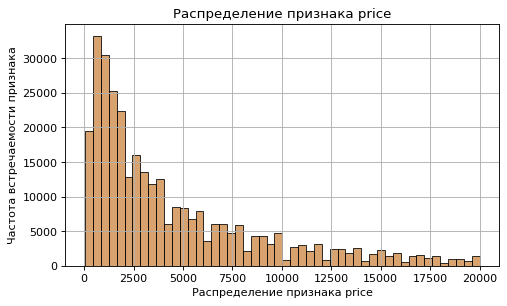

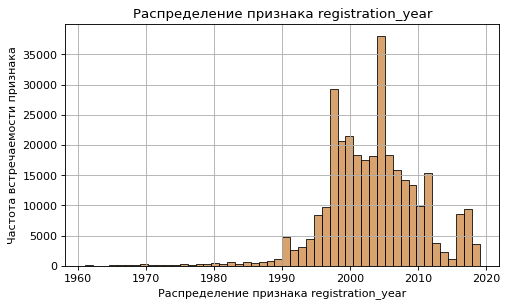

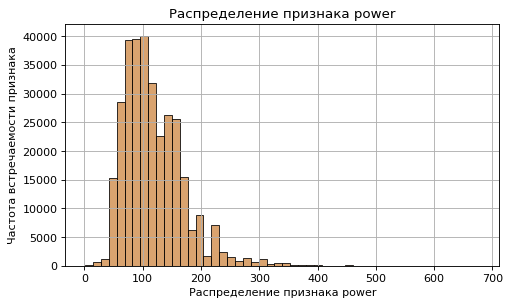

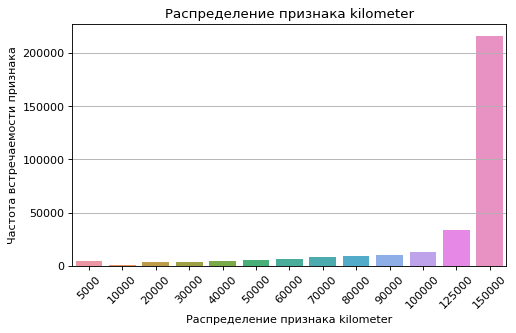

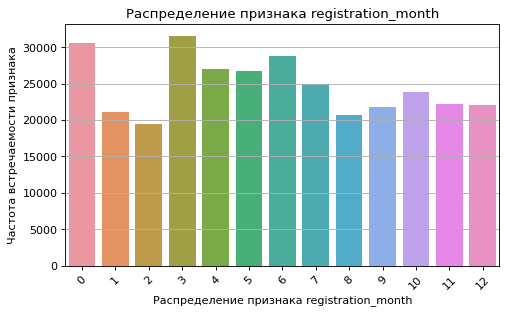

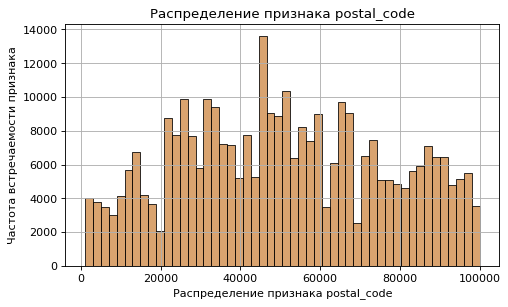

In [51]:
#выделим только количественные признаки, создав из них список
for c in data_main.select_dtypes(exclude='object').columns.tolist():
    plt.figure(figsize = (7,4), dpi = 80)
    plt.grid()
    plt.ylabel('Частота встречаемости признака')
    plt.xlabel(f'Распределение признака {c}')
    plt.title(f'Распределение признака {c}')
    if (data_main[c].dtype == 'int64') and (len(data_main[c].unique()) < 30):
        sns.countplot(data = data_main, x=c)
        plt.ylabel('Частота встречаемости признака')
        plt.xlabel(f'Распределение признака {c}')
        plt.xticks(rotation=45) 
        plt.show()
    else:
        sns.histplot(data = data_main, x = c, color = 'peru', bins = 50)         
        plt.show() 

Теперь посмотрим на распределение категориальных признаков датафрейма:

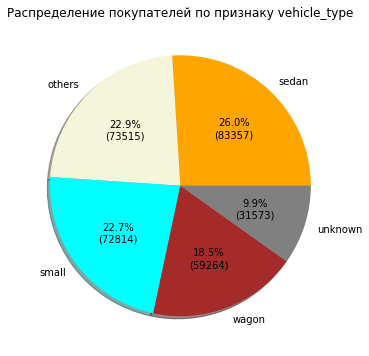

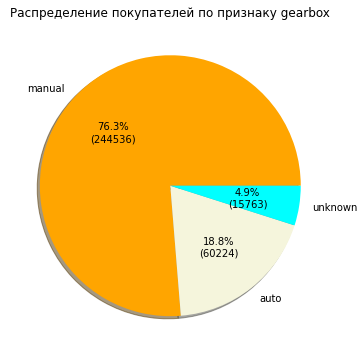

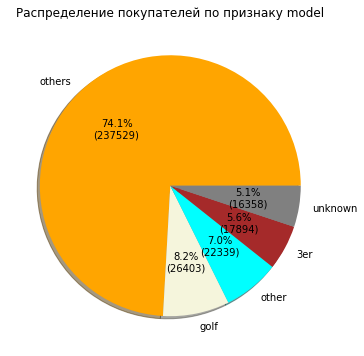

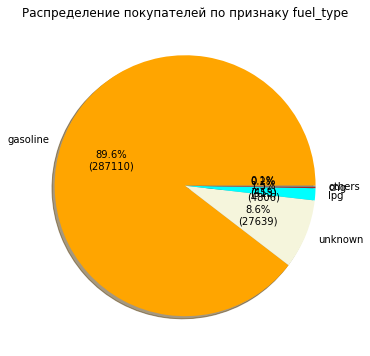

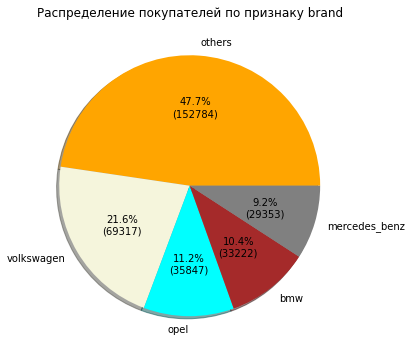

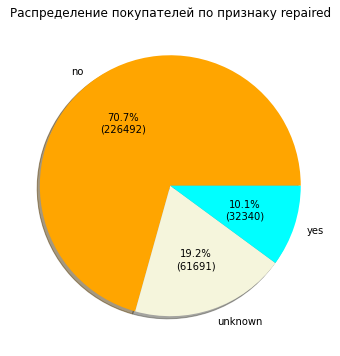

In [52]:
#добавим сразу свой набор цветов для графиков
colors = ("orange", "beige","cyan", "brown","grey", "green")
#выделим только категориальные признаки, создав из них список
for c in data_main.select_dtypes(include='object').columns.tolist(): 
    #добавляем столбец для хранения в нем либо топ-5 названий на каждой итерации цикла, которые будут сменять друг друга,
#перезаписывая значение столбца, либо для замены названия всех остальных значений на `другие`     
    data_main['group_pie'] = data_main[c].where(data_main[c].\
#создаем список для топ-4 значений по количеству, с ним и будет проверяться значение столбца
#из цикла и при совпадении значение неизменным запишется в новый столбец 'group_pie', а при несовпадении 
#значение поменяется на 'others'
    isin(data_main.pivot_table(index = c,values = 'price', aggfunc=('count')).sort_values(by = 'price', ascending = False).index[:4]),'others')
#создаем сводную таблицу, группируя по новому столбцу 'group_pie' и строим график
    data_main.pivot_table(index = data_main['group_pie'], values = 'price', aggfunc={'count'}).sort_values(by= 'count', ascending = False).\
                plot(kind = 'pie', y = 'count',figsize = (6,6), legend = False, shadow=True,\
#добавим lambda функцию для отображения и процентов и кол-ва точного каждой группы, в f строке в первые фигурные ковычки просто
#выводится x - это отображения в процентах каждой группы в параметре autopct по умолчанию, а во вторых фигруных скобках добавим
#небольшое вычисление через проценты, количества в каждой группе, используя общее кол-во строк в таблице, этот метод точен только
#до 3 знака после замятов отображении элементов
                autopct= lambda x: '{:.1f}%\n({:.0f})'.format(x,(x* data_main.shape[0]/100)), colors = colors, fontsize = 10)
    plt.xlabel('')
    plt.ylabel('')
    plt.title(f'Распределение покупателей по признаку {c}')
    plt.show()
#удаляем наш технический столбец после отработки его функции
data_main = data_main.drop('group_pie', axis = 1)

**Полученные графики для количественных признаков показывают следующее:**
- самая распространенная цена автомобиля находится в диапазоне от 1000 до 1500 евро, с увеличением цены кол-во машин логично уменьшается.
- чаще всего машины встречаются с годом регистрации 2005 и 1997 года. Все подавляющее большинство машин имеет диапазон годов регистрации с 1990 по 2019 год
- чаще всего встречаются автомобили с мощностью в районе 100 л.с. Больше всего автомобили имеются мощности в диапазоне от 50 до 200 л.с. 
- подавляющее большинство автомобилей имеет пробег в районе 150 000 км
- Распределение по месяцам регистрации автомобилей равномерное

**Полученные графики для категориальных признаков позволяют сделать следующие выводы:**
- тройка лидеров по типу кузова:
  - `sedan` - 26.1% (88931 автомобиль)
  - `small` - 22.8% (77658 автомобилей)
  - `wagon` - 18.6% (63435 автомобилей)
- по типу коробки передач лидирует механическая коробка `manual` - 76.2% от общего количества, 259996 автомобиля
- больше всего моделей автомобилей golf – 8.2% от общего количества – 28097 автомобиля
- по типу топлива лидирует бензин – 89.9% от общего числа автомобилей – 306405.
  - Тройка лидеров по марке автомобилей:
  - Volkswagen -21.7% (73934 автомобиля)
  - Opel – 11.2% (38210 автомобиля)
  - BMW – 10.4% (35522 автомобиля)

## Корреляционный анализ

Построим матрицу корреляции для возможного выявления мультиколлинеарности между входными признаками. Так как присутствуют в данных нелинейные зависимости и категориальные признаки, то воспользуемся матрицей корреляции `phik`. Так как присутствуют непрерывные признаки, то их наименования передадим в переменную `interval_cols`. Хоть целочисленное значение цены и мощности автомобиля сами по себе являются дискретными величинами, но учитывая кол-во объектов и гистрограмму распределения как для непрерывной величины, лучше рассматривать эти величины в конкретном случае в качестве непрерывных величин.

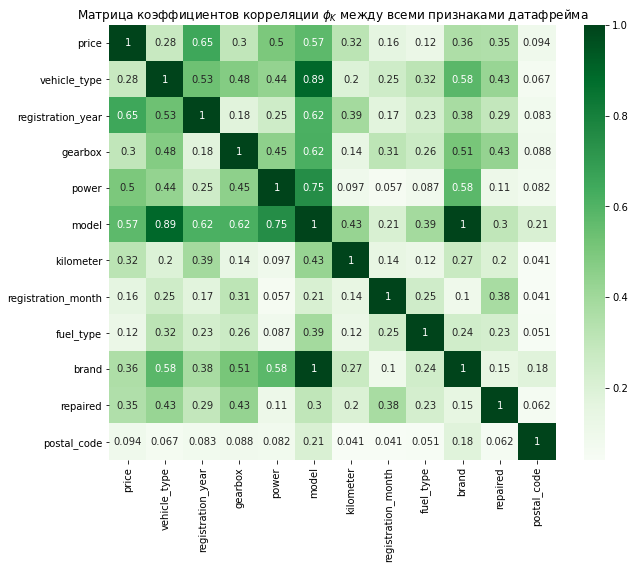

In [53]:
interval_cols = [
    'price',
    'postal_code',
    'power',
    'registration_year'
]

plt.figure(figsize = (10,8))
sns.heatmap(data_main.phik_matrix(interval_cols=interval_cols), annot=True, cmap='Greens')
plt.title(r'Матрица коэффициентов корреляции $\phi_K$ между всеми признаками датафрейма')
plt.show()

Наблюдается мультиколлинеарность между входными признаками `model` и `brand`, так как модель автомобиля однозначно определяет его, то можно марку автомобиля удалить из входных признаков и оставить только столбец с моделью, тем более корреляция между целевым признаком `price` и `model` намного выше, чем между `price` и `brand`. Столбец `postal_code` имеет ненулевую корреляцию с целевым признаком, поэтому его можно оставить.

In [54]:
data_main = data_main.drop(['brand'], axis=1).reset_index(drop = True)

Проверим размерность

In [55]:
data_main.shape

(320523, 11)

**На этапе корреляционного анализа были получены следующие результаты:**
- между входными признаками `brand` и `model` присутствует мультиколлинеарность, поэтому было принято решение удалить признак `brand`.
- также во входных признаках наблюдается сильная корреляция между `model` и `vehicle_type`
- корреляция с целевым признаком больше всего у признаков `registrarion_year`, `model` и  `power`.

## Обучение моделей

В нашем исследовании будем использовать несколько моделей: KNeighborsRegressor(), DecisionTreeRegressor() и две модели бустинга - CatBoostRegressor() и LGBMRegressor(). Так как модели бустинга обучаются долго, особенно долго обучается LGBMRegressor(), то у нее возьмем один набор гиперпараметров, а у модели  CatBoostRegressor() тоже добавим небольшой диапазон значений только в одном гиперпараметре. Так как в моделях бустинга будет мало гиперпараметров, то будем использовать GridSearchCV(), а для двух других моделей используем RandomizedSearchCV(). Для удобства будем использовать пайплайны. Итоговые результаты по качеству и времени работы моделей получим из таблицы `cv_results_`. Время работы посмотрим при помощи метода `.time()`, посчитав сколько времени занимает именно выполнение автоматизированного подбора гиперпараметров из всего кода в ячейке.

Сначала подготовим выборки для обучения

In [56]:
X_train, X_test, y_train, y_test = train_test_split(
    data_main.drop(['price'], axis=1),
    data_main['price'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE
)

Следующим шагом создадим отдельные списки для столбцов, которые будут масштабироваться и кодироваться разными способами. Хоть категориальные признаки не ранжируются и можно было бы применить OHE-кодирование, но так как в столбце `model` огромное количество категорий, то при использовании OHE-кодирования расчеты уходят в бесконечность. Так как мы используем нелинейные модели, то в этом случае можно использовать OrdinalEncoder(), просто в него не будем передавать проранжированные списки с категориями. 

In [57]:
ord_columns = [
    'vehicle_type',
    'gearbox',
    'model',
    'fuel_type',
    'repaired'
]

num_columns = ['registration_year',
               'power',
               'kilometer',
              'registration_month',
               'postal_code'
              ] 

Создадим общий пайплайн для предобработки данных, включающий замену неизвестных категориий при кодировании в OrdinalEncoder() на самое частое значение в данном категориальном столбце при помощи SimpleImputer(), так как при разбиении на тренировочную и тестовую выборку из-за огромного количества категорий в столбце `model` в тестовой выборке могут образоваться неизвестные категории

In [58]:
# cоздаём пайплайн для подготовки признаков из списка ord_columns: заполнение пропусков и Ordinal-кодирование
# + SimpleImputer
ord_pipe = Pipeline(
    [
        (
            'simpleImputer_before_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord', OrdinalEncoder(
                handle_unknown='use_encoded_value',
                unknown_value=np.nan
            )
        ),
        (
            'simpleImputer_after_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)


# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [
        ('ord', ord_pipe, ord_columns),
        ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
)
print(data_preprocessor)

ColumnTransformer(remainder='passthrough',
                  transformers=[('ord',
                                 Pipeline(steps=[('simpleImputer_before_ord',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ord',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=nan)),
                                                 ('simpleImputer_after_ord',
                                                  SimpleImputer(strategy='most_frequent'))]),
                                 ['vehicle_type', 'gearbox', 'model',
                                  'fuel_type', 'repaired']),
                                ('num', StandardScaler(),
                                 ['registration_year', 'power', 'kilometer',
                                  'registration_month', 'postal_co

### Написание функции для расчета RMSE

Так как встроенной метрики RMSE нет, то напишем свою простую функцию для подсчета этой метрики. Для того, чтобы можно было использовать метрику при кросс-валидации при автоматизированном поиске гиперпараметров, то воспользуемся `make_scorer`. Также укажем параметр `greater_is_better=False`, так как в нашем случае мы пытаемся минимизировать ошибку. Если захотим вывести итоговую таблицу работы всех моделей `cv_results_`, то просто умножим столбец со значением метрики на `-1`, чтобы увидеть реальное значение метрики

In [59]:
def rmse_score(y_real,y_preds):
    return np.sqrt(mean_squared_error(y_real,y_preds))

rmse_score_sv = make_scorer(
    rmse_score,
    greater_is_better=False
)

### Обучение моделей DecisionTreeRegressor() и KNeighborsRegressor()

Соберем наш итоговый первый пайплайн с моделями DecisionTreeRegressor() и KNeighborsRegressor(), для подбора гиперпараметров будем использовать RandomizedSearchCV() и зададим небольшое количество итераций - 30, так как при сильном увеличении количества итераций время расчета становится слишком большим, а качество метрики у моделей все равно уступает моделям бустинга.

In [60]:
pipe_one = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeRegressor())
])

param_rend = [
    # словарь для модели DecisionTreeRegressor()
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(2,16),
        'models__min_samples_split' : range(2,8),
        'models__min_samples_leaf': range(1,6),
        'models__max_features': range(2,9),
        'preprocessor__num': [StandardScaler()]
    },
    # словарь для модели KNeighborsRegressor()
    {
        'models': [KNeighborsRegressor()],
        'models__n_neighbors': range(2,9),
        'preprocessor__num': [StandardScaler()]
    }
]

# запускаем таймер для проверки длительности поиска при GridSearchCV
start = time.time()

randomized_search = RandomizedSearchCV(
    pipe_one, 
    param_distributions=param_rend, 
    cv=5, 
    scoring= rmse_score_sv,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    n_iter=30
)
randomized_search.fit(X_train, y_train) 

randomized_search_time = time.time() - start
print('Характеристики при RandomizedSearchCV')
print(f'Время подбора гиперпараметров для моделей: {randomized_search_time}')


print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика RMSE для лучшей модели, полученная при кросс-валидации:', abs(randomized_search.best_score_))

Характеристики при RandomizedSearchCV
Время подбора гиперпараметров для моделей: 147.98893094062805
Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=nan)),
                                                                  ('simpleImputer_after_ord',
                                                                   SimpleImputer(strategy='most_frequent'))]),
              

Лучшей моделью из этих двух оказалась модель DecisionTreeRegressor(max_depth=14, max_features=8,  min_samples_leaf=4, min_samples_split=4), метрика RMSE при кросс-валидации 2022.34. Выведем таблицу с лучшими 5 моделями и основными показателями, которые важны для заказчика

In [61]:
#устанавливаем настройки, чтобы таблица с результатами отображалась полностью
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

#получаем таблицу с работой всех моделей
result_models_rate = pd.DataFrame(randomized_search.cv_results_)

#для корректного отображения среднего значения метрики RMSE умножаем столбец на -1 
result_models_rate[
    'mean_test_score'
] = result_models_rate['mean_test_score'] * -1

result_models_rate = result_models_rate.sort_values(by = 'rank_test_score')

#отображаем нужные столбцы и выводим для наглядности первые 5 лучших моделей
display(result_models_rate[
    ['rank_test_score', 'param_models','mean_test_score','mean_fit_time', 'mean_score_time','params']
                        ].head(10))

,rank_test_score,param_models,mean_test_score,mean_fit_time,mean_score_time,params
5,1,DecisionTreeRegressor(random_state=42),2022.342031,1.030483,0.072583,"{'preprocessor__num': StandardScaler(), 'models__min_samples_split': 4, 'models__min_samples_leaf': 4, 'models__max_features': 8, 'models__max_depth': 14, 'models': DecisionTreeRegressor(random_state=42)}"
15,2,DecisionTreeRegressor(random_state=42),2023.251749,1.006636,0.074089,"{'preprocessor__num': StandardScaler(), 'models__min_samples_split': 7, 'models__min_samples_leaf': 5, 'models__max_features': 8, 'models__max_depth': 13, 'models': DecisionTreeRegressor(random_state=42)}"
27,3,DecisionTreeRegressor(random_state=42),2033.475373,1.043040,0.072503,"{'preprocessor__num': StandardScaler(), 'models__min_samples_split': 4, 'models__min_samples_leaf': 4, 'models__max_features': 8, 'models__max_depth': 15, 'models': DecisionTreeRegressor(random_state=42)}"
21,4,DecisionTreeRegressor(random_state=42),2038.473554,0.847395,0.070761,"{'preprocessor__num': StandardScaler(), 'models__min_samples_split': 2, 'models__min_samples_leaf': 4, 'models__max_features': 7, 'models__max_depth': 12, 'models': DecisionTreeRegressor(random_state=42)}"
29,5,DecisionTreeRegressor(random_state=42),2049.331649,0.863850,0.069530,"{'preprocessor__num': StandardScaler(), 'models__min_samples_split': 6, 'models__min_samples_leaf': 2, 'models__max_features': 7, 'models__max_depth': 12, 'models': DecisionTreeRegressor(random_state=42)}"
22,6,DecisionTreeRegressor(random_state=42),2054.087141,0.735632,0.069254,"{'preprocessor__num': StandardScaler(), 'models__min_samples_split': 6, 'models__min_samples_leaf': 5, 'models__max_features': 5, 'models__max_depth': 12, 'models': DecisionTreeRegressor(random_state=42)}"
17,7,DecisionTreeRegressor(random_state=42),2065.606760,0.787138,0.069236,"{'preprocessor__num': StandardScaler(), 'models__min_samples_split': 6, 'models__min_samples_leaf': 4, 'models__max_features': 6, 'models__max_depth': 11, 'models': DecisionTreeRegressor(random_state=42)}"
4,8,DecisionTreeRegressor(random_state=42),2068.556325,0.826712,0.072225,"{'preprocessor__num': StandardScaler(), 'models__min_samples_split': 4, 'models__min_samples_leaf': 3, 'models__max_features': 5, 'models__max_depth': 15, 'models': DecisionTreeRegressor(random_state=42)}"
6,9,DecisionTreeRegressor(random_state=42),2088.326368,0.796144,0.068546,"{'preprocessor__num': StandardScaler(), 'models__min_samples_split': 2, 'models__min_samples_leaf': 1, 'models__max_features': 7, 'models__max_depth': 10, 'models': DecisionTreeRegressor(random_state=42)}"
7,10,KNeighborsRegressor(),2091.620403,0.792543,5.691201,"{'preprocessor__num': StandardScaler(), 'models__n_neighbors': 7, 'models': KNeighborsRegressor()}"


Как видно из результата, из лучших десяти моделей девять оказались модели DecisionTreeRegressor(). Также видно, что время для прогнозирования и оценивания `mean_score_time` у KNeighborsRegressor() кратно больше, чем у деревянной модели. Если бы мы рассматривали только две эти модели, то лучшей бы мы выбрали модель **DecisionTreeRegressor** и для нее уже бы подобрали еще лучшие гиперпараметры, указав большие диапазоны и большее количество итераций.

### Обучение моделей CatBoostRegressor() и LGBMRegressor()

Теперь соберем итоговый второй пайплайн с моделями бустинга CatBoostRegressor() и LGBMRegressor(). Так как они обучаются намного дольше, особенно LGBMRegressor(), то зададим всего несколько гиперпараметров у CatBoostRegressor(), а у модели LGBMRegressor() всего 1 набор гиперпараметров.

In [62]:
pipe_two = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', CatBoostRegressor())
])

param_grid = [
    # словарь для модели CatBoostRegressor()
    {
        'models': [CatBoostRegressor(verbose = 0, 
                                     loss_function = 'RMSE')],
        'models__depth': range(5,7),
        'models__iterations' : [1000],
        'models__learning_rate': [0.03, 0.1],
        'preprocessor__num': [StandardScaler()]
            },
    #словарь для модели LGBMRegressor()
        {
        'models': [LGBMRegressor(verbose = -1, 
                                 n_estimators = 1000, 
                                 num_leaves = 31, 
                                 learning_rate=0.1, 
                                 metric='rmse', 
                                 max_depth = 6)],
        'preprocessor__num': [StandardScaler()]
    }
]

start = time.time()

grid = GridSearchCV(
    pipe_two, 
    param_grid=param_grid, 
    cv=5, 
    scoring= rmse_score_sv,
    n_jobs=-1
)
grid.fit(X_train, y_train) 

grid_search_time = time.time() - start
print('\n\nХарактеристики при GridSearchCV')
print(f'Время подбора гиперпараметров для моделей: {grid_search_time}')

print('Лучшая модель и её параметры на тренировочном датасете:\n\n', grid.best_estimator_)
print('Метрика RMSE для лучшей модели, полученная при кросс-валидации:\n', abs(grid.best_score_))



Характеристики при GridSearchCV
Время подбора гиперпараметров для моделей: 778.311970949173
Лучшая модель и её параметры на тренировочном датасете:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=nan)),
                                                                  ('simpleImputer_after_ord',
                                                                   SimpleImputer(strategy='most_frequent'

Лучшую метрику RMSE = 1671.05 показала модель LGBMRegressor() со стандартным набором гиперпараметров. Сравним лучшие модели по таблице результатов

In [63]:
#получаем таблицу с работой всех моделей
result_models_rate_2 = pd.DataFrame(grid.cv_results_)

#для корректного отображения среднего значения метрики RMSE умножаем столбец на -1 
result_models_rate_2[
    'mean_test_score'
] = result_models_rate_2['mean_test_score'] * -1

result_models_rate_2 = result_models_rate_2.sort_values(by = 'rank_test_score')

#отображаем нужные столбцы и выводим для наглядности первые 5 лучших моделей
display(result_models_rate_2[
    ['rank_test_score', 'param_models','mean_test_score','mean_fit_time', 'mean_score_time','params']
                        ].head(5))

,rank_test_score,param_models,mean_test_score,mean_fit_time,mean_score_time,params
4,1,"LGBMRegressor(max_depth=6, metric='rmse', n_estimators=1000, verbose=-1)",1671.049558,32.875951,5.714944,"{'models': LGBMRegressor(max_depth=6, metric='rmse', n_estimators=1000, verbose=-1), 'preprocessor__num': StandardScaler()}"
3,2,<catboost.core.CatBoostRegressor object at 0x7f1881d1f790>,1716.725310,28.241966,0.228842,"{'models': <catboost.core.CatBoostRegressor object at 0x7f1881d1f790>, 'models__depth': 6, 'models__iterations': 1000, 'models__learning_rate': 0.1, 'preprocessor__num': StandardScaler()}"
1,3,<catboost.core.CatBoostRegressor object at 0x7f1881d1f790>,1743.922331,25.989351,0.226560,"{'models': <catboost.core.CatBoostRegressor object at 0x7f1881d1f790>, 'models__depth': 5, 'models__iterations': 1000, 'models__learning_rate': 0.1, 'preprocessor__num': StandardScaler()}"
2,4,<catboost.core.CatBoostRegressor object at 0x7f1881d1f790>,1820.120536,28.526390,0.224244,"{'models': <catboost.core.CatBoostRegressor object at 0x7f1881d1f790>, 'models__depth': 6, 'models__iterations': 1000, 'models__learning_rate': 0.03, 'preprocessor__num': StandardScaler()}"
0,5,<catboost.core.CatBoostRegressor object at 0x7f1881d1f790>,1854.725857,25.848757,0.228535,"{'models': <catboost.core.CatBoostRegressor object at 0x7f1881d1f790>, 'models__depth': 5, 'models__iterations': 1000, 'models__learning_rate': 0.03, 'preprocessor__num': StandardScaler()}"


Как видно из полученных результатов, модель **LGBMRegressor()** показала немного лучшую метрику, чем лучшая модель CatBoostRegressor(), но время предсказания и время обучения оказалось намного дольше, чем у CatBoostRegressor(). 

**На этапе составления полного пайплайна были подобраны несколько моделей с лучшими гиперпараметрами, проанализируем результаты**

### Анализ результатов моделей

Составим итоговую таблицу с результатами из лучших моделей каждого типа и выберем лучшую, из первого пайплайна возьмем только лучшую деревянную модель

In [64]:
pd.concat([
        result_models_rate[['param_models','mean_test_score','mean_fit_time', 'mean_score_time','params']].head(1),
        result_models_rate_2[['param_models','mean_test_score','mean_fit_time', 'mean_score_time','params']].head(2)
        ], axis = 0)

,param_models,mean_test_score,mean_fit_time,mean_score_time,params
5,DecisionTreeRegressor(random_state=42),2022.342031,1.030483,0.072583,"{'preprocessor__num': StandardScaler(), 'models__min_samples_split': 4, 'models__min_samples_leaf': 4, 'models__max_features': 8, 'models__max_depth': 14, 'models': DecisionTreeRegressor(random_state=42)}"
4,"LGBMRegressor(max_depth=6, metric='rmse', n_estimators=1000, verbose=-1)",1671.049558,32.875951,5.714944,"{'models': LGBMRegressor(max_depth=6, metric='rmse', n_estimators=1000, verbose=-1), 'preprocessor__num': StandardScaler()}"
3,<catboost.core.CatBoostRegressor object at 0x7f1881d1f790>,1716.725310,28.241966,0.228842,"{'models': <catboost.core.CatBoostRegressor object at 0x7f1881d1f790>, 'models__depth': 6, 'models__iterations': 1000, 'models__learning_rate': 0.1, 'preprocessor__num': StandardScaler()}"


**Полученные результаты лучшей модели каждого вида показывают следующее:**
 - метрика RMSE намного лучше оказалась у моделей бустинга LGBMRegressor() и CatBoostRegressor(), чем у моделей KNeighborsRegressor() и DecisionTreeRegressor()
 - хоть модель LGBMRegressor() и показала метрику чуть лучше, чем модель CatBoostRegressor(), но время обучения у нее оказалось дольше, а прогнозное время  модели оказалось почти в 30 раз дольше.
 - время обучения `mean_fit_time` у моделей бустинга в десятки раз превысило остальные модели.
 - учитывая все эти результаты, **лучшей моделью является CatBoostRegressor() со стандартным набором параметров iterations = 1000, learning_rate = 0.1, depth = 6**, так как ее метрика RMSE совсем немного хуже, чем у LGBMRegressor(), но вот время предсказания и оценивания работы кратно меньше (еще при некоторых повторениях время обучения LGBMRegressor() оказывалось в два раза дольше, чем у CatBoostRegressor()). И если сравнить с деревянной моделью, то по времени обучения, конечно, модель градиентного бустинга проигрывает, но обучение мы делаем один раз, а предсказаний много, а длительность предсказания у них отличается буквально на десятую долю, зато метрика RMSE намного лучше у модели CatBoostRegressor().

### Проверка на тестовых данных

Осталось проверить, что метрика не сильно ухудшается на тестовых данных. Сделаем прогноз с помощью лучшей модели и посмотрим на метрику. Так как лучшей моделью была выбрана модель CatBoostRegressor(), а в GridSearch() сохраняется только лучшая обученная модель, то заново обучим модель CatBoostRegressor() и сделаем предсказания на тестовой выборке. Так как этой модели можно передавать данные без предобработки, то передадим данные в сыром виде в качестве эксперимента. Также при обучении передадим список категорильных столбцов `cat_features=ord_columns`

In [65]:
%%time 

# Инициализация модели
best_model = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.1,
    depth=6,
    loss_function='RMSE',
    verbose=500
)
#время начала обучения модели
start_fit = time.time()

#обучение модели, также передаем список категориальных столбцов
best_model.fit(X_train, y_train, cat_features=ord_columns)

#полное время обучения модели
best_model_fit_time = time.time() - start_fit

print(f'Время обучения модели: {best_model_fit_time}')

0:	learn: 4217.2423410	total: 322ms	remaining: 5m 22s
500:	learn: 1706.7238720	total: 1m 46s	remaining: 1m 45s
999:	learn: 1643.2352870	total: 3m 36s	remaining: 0us
Время обучения модели: 220.10486841201782
CPU times: user 3min 37s, sys: 729 ms, total: 3min 38s
Wall time: 3min 40s


Время обучения в 218 секунд на сырых данных совсем не радует, тем более что при работе GridSearchCV() на предобработанных данных время обучения составляло около 30 секунд, проверим время обучения, если передать предобработанные данные

In [66]:
#подгатавливаем данные для обучения
X_train_transform = pd.DataFrame(
    grid.best_estimator_.named_steps['preprocessor'].transform(X_train),
    columns = grid.best_estimator_.named_steps['preprocessor'].get_feature_names_out()    
) 

X_test_transform = pd.DataFrame(
    grid.best_estimator_.named_steps['preprocessor'].transform(X_test),
    columns = grid.best_estimator_.named_steps['preprocessor'].get_feature_names_out() 
)

Заново обучим модель и сделаем прогноз на тестовых данных

In [67]:
%%time 

# Инициализация модели
best_model = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.1,
    depth=6,
    loss_function='RMSE',
    verbose=0
)
#время начала обучения модели
start_fit = time.time()

#обучение модели
best_model.fit(X_train_transform, y_train)

#полное время обучения модели
best_model_fit_time = time.time() - start_fit

#время начала предсказания модели
start_pred = time.time()

# Оценка модели
preds = best_model.predict(X_test_transform)

#так как не используем кросс-валидацию, то используем непосредственно функцию rmse_score для расчета метрики
best_model_rmse_test = rmse_score(y_test, preds)
print(f'\nRMSE лучшей модели на тестовой выборке: {best_model_rmse_test:.2f}')

#полное время предсказания модели
best_model_preds_time = time.time() - start_pred

print(f'\nВремя обучения модели: {best_model_fit_time}')
print(f'Прогнозное время модели: {best_model_preds_time}')


RMSE лучшей модели на тестовой выборке: 1702.98

Время обучения модели: 33.666609048843384
Прогнозное время модели: 0.08505463600158691
CPU times: user 32.6 s, sys: 160 ms, total: 32.8 s
Wall time: 33.8 s


**Результаты лучшей модели CatBoostRegressor() на тестовой выборке получились следующие:**
 - метрика RMSE  1702.98,
 - прогнозное время составило 0.08 секунды
 - при этом время при повторном обучении модели на тренировочной выборке с предобработанными данными составило 35 секунд, а на "сырых" данных 218 секунд

Осталось проверить модель на адекватность

### Проверка модели на адекватность

Осталось сравнить результаты, предсказанные с помощью нашей лучшей модели, с результатами модели `DummyRegressor()`. Эта модель использует несколько типов стратегий, мы остановимся на стандартном, когда всем прогнозным значениям присваивается среднее значение целевого признака.

Объявим константную модель, в качестве стратегии укажем `mean`. Обучим ее на тренировочном датасете, получим прогноз тестовой выборки и сравним метрику RMSE у нее и у наших моделей. Для модели DummyRegressor() не будем подготавливать тренировочные данные, так как она использует значения целевого признака для предсказания

In [68]:
#объявляем модель и указываем тип стратегии
dummy_model_regression = DummyRegressor(strategy = 'mean').fit(X_train, y_train)

#получаем прогнозные значения DummyRegressor()
dummy_regression_predict = dummy_model_regression.predict(X_test)
#считаем метрику RMSE и выводим ее, так как не используем кросс-валидацию, то используем непосредственно функцию rmse_score
print(f'Метрика RMSE Dummy модели на тестовой выборке: {rmse_score(y_test, dummy_regression_predict)}')

Метрика RMSE Dummy модели на тестовой выборке: 4499.121915837344


**Наша лучшая модель справилась с проверкой на адекватность и показала метрику RMSE намного ниже, чем у константной модели DummyRegressor()**

**При составлении пайплайнов для подбора гиперпараметров сразу нескольким моделям были проделаны следующие шаги и получены следующие результаты**
- создано несколько пайплайнов, включающие:
  - подготовку данных:
   - кодирование категориальных признаков при помощи OrdinalEncoder()
   - масштабирование количественных признаков при помощи StandardScaler()
   - перебор гиперпараметров для разных моделей в 2 пайплайнах:
     - в первом пайплайне для моделей DecisionTreeRegressor() и KNeighborsRegressor() со словарями их гиперпараметров при помощи инструмента автоматизированного подбора RandomizedSearchCV().
     - во втором пайплайне для моделей CatBoostRegressor() и LGBMRegressor() со словарями их гиперпараметров при помощи инструмента автоматизированного подбора GridSearchCV()
- для оценивания качества работы моделей была созданна функция для расчета метрики RMSE, которая при помощи `make_scorer` была применена при автоматизированном поиске гиперпараметров
- при автоматизированном поиске гиперпараметров были получены следующие результаты:
  - метрика RMSE намного лучше оказалась у моделей бустинга LGBMRegressor() и CatBoostRegressor(), чем у моделей KNeighborsRegressor() и DecisionTreeRegressor()
 - хоть модель LGBMRegressor() и показала метрику лучше, чем модель CatBoostRegressor(), но время обучения у нее оказалось дольше почти в два раза, а прогнозное время  модели оказалось почти в 30 раз дольше.
  - время обучения `mean_fit_time` у моделей бустинга в десятки раз превысило остальные модели.

**Лучшей моделью оказалась CatBoostRegressor() со стандартным набором гиперпараметров: iterations = 1000, learning_rate = 0.1, depth = 6**, так как ее метрика RMSE немного хуже, чем у LGBMRegressor, но вот время предсказания и оценивания работы кратно меньше. И если сравнить с деревянной моделью, то по времени обучения, конечно, модель градиентного бустинга проигрывает, но обучение мы делаем один раз, а предсказаний много, а длительность предсказания у них отличается буквально на десятую долю, зато метрика RMSE намного лучше у модели CatBoostRegressor().

  - лучшая модель была подобрана за 719 секунд при использовании GridSearchCV().
  - метрика RMSE при кросс-валидации составила 1716

**Результаты лучшей модели CatBoostRegressor() на тестовой выборке получились следующие:**
 - метрика RMSE 1702.98,
 - прогнозное время составило 0.08 секунды
 - при этом время при повторном обучении модели на тренировочной выборке с предобработанными данными составило 35 секунд, на сырых данных 218 секунд
 
- также модель прошла проверку на адекватность, метрика RMSE оказалась намного ниже, чем у модели DummyRegressor()

## Итоговые выводы

**В результате исследования были получены следующие результаты:**

**На этапе предобработки данных были выполнены следующие действия и получены следующие результаты:**
- в наименованиях столбцов добавлены нижние подчеркивания. Столбцы приведены к змеиному регистру, лишних пробелов не обнаружено.
- пропущенные значения в категориальных столбцах заменены на значения-заглушки.
- во время обработки аномалий были выполены следующие основные действия:**
  - были удалены объекты со значением в столбце `price` менее 50 евро
  - были удалены объекты со значением в столбце `registration_year` автомобиля больше 2025 и меньше 1960
  - были удалены объекты со значением в столбце `power` более 700 л.с., среди объектов от 500 л.с. до 700 л.с. были удалены объекты со стоимостью менее 7000 евро
  - в столбце `power` значения 0 были заменены на медианные значения мощности автомобилей для каждой марки
  - у автомобилей с мощностью менее 20 л.с. и годом регистрации больше 2000 значение мощности было заменено на медианное значение мощности для автомобиля с  учетом марки и года выпуска больше, чем 2000
- удалены явные дубликаты из датафрейма
- удалены неявные дубликаты из датафрейма с анкетами автомобилей, которые были загружены несколько раз
- заменены дублирующиеся значения одного и того же типа топлива
- удалены неинформативные столбцы `date_crawled`, `date_created` , `last_seen` и `number_of_pictures` и образовавшиеся явные дубликаты после их удаления

**На этапе исследовательского анализа были получены следующие результаты:**

Полученные графики для количественных признаков показали следующее:
- самая распространенная цена автомобиля находится в диапазоне от 1000 до 1500 евро, с увеличением цены кол-во машин логично уменьшается.
- чаще всего машины встречаются с годом регистрации 2005 и 1997 года. Все подавляющее большинство машин имеет диапазон годов регистрации с 1990 по 2019 год
- чаще всего встречаются автомобили с мощностью в районе 100 л.с. Больше всего автомобили имеются мощности в диапазоне от 50 до 200 л.с. 
- подавляющее большинство автомобилей имеет пробег в районе 150 000 км
- Распределение по месяцам регистрации автомобилей равномерное

Полученные графики для категориальных признаков показали следующее:
- тройка лидеров по типу кузова:
  - `sedan` - 26.1% (88931 автомобиль)
  - `small` - 22.8% (77658 автомобилей)
  - `wagon` - 18.6% (63435 автомобилей)
- по типу коробки передач лидирует механическая коробка `manual` - 76.2% от общего количества, 259996 автомобиля
- больше всего моделей автомобилей golf – 8.2% от общего количества – 28097 автомобиля
- по типу топлива лидирует бензин – 89.9% от общего числа автомобилей – 306405.
  - Тройка лидеров по марке автомобилей:
  - Volkswagen -21.7% (73934 автомобиля)
  - Opel – 11.2% (38210 автомобиля)
  - BMW – 10.4% (35522 автомобиля)
 
**На этапе корреляционного анализа были получены следующие результаты:**
- между входными признаками `brand` и `model` присутствует мультиколлинеарность, поэтому было принято решение удалить признак `brand`.
- также во входных признаках наблюдается сильная корреляция между `model` и `vehicle_type`
- корреляция с целевым признаком больше всего у признаков `registrarion_year`, `model` и  `power`.

**При составлении пайплайнов для подбора гиперпараметров сразу нескольким моделям были проделаны следующие шаги и получены следующие результаты**
- создано несколько пайплайнов, включающиие:
  - подготовку данных:
   - кодирование категориальных признаков при помощи OrdinalEncoder()
   - масштабирование количественных признаков при помощи StandardScaler()
   - перебор гиперпараметров для разных моделей в 2 пайплайнах:
     - в первом пайплайне для моделей DecisionTreeRegressor() и KNeighborsRegressor() со словарями их гиперпараметров при помощи инструмента автоматизированного подбора RandomizedSearchCV().
     - во втором пайплайне для моделей CatBoostRegressor() и LGBMRegressor() со словарями их гиперпараметров при помощи инструмента автоматизированного подбора GridSearchCV()
- для оценивания качества работы моделей была созданна функция для расчета метрики RMSE, которая при помощи make_scorer была применена при автоматизированном поиске гиперпараметров
- при автоматизированном поиске гиперпараметров были получены следующие результаты:
  - метрика RMSE намного лучше оказалась у моделей бустинга LGBMRegressor() и CatBoostRegressor(), чем у моделей KNeighborsRegressor() и DecisionTreeRegressor()
 - хоть модель LGBMRegressor() и показала метрику лучше, чем модель CatBoostRegressor(), но время обучения у нее оказалось дольше почти в два раза, а прогнозное время  модели оказалось почти в 30 раз дольше.
  - время обучения `mean_fit_time` у моделей бустинга в десятки раз превысило остальные модели.

**Лучшей моделью оказалась CatBoostRegressor() со стандартным набором гиперпараметров: iterations = 1000, learning_rate = 0.1, depth = 6**, так как ее метрика RMSE немного хуже, чем у LGBMRegressor, но вот время предсказания и оценивания работы кратно меньше. И если сравнить с деревянной моделью, то по времени обучения, конечно, модель градиентного бустинга проигрывает, но обучение мы делаем один раз, а предсказаний много, а длительность предсказания у них отличается буквально на десятую долю, зато метрика RMSE намного лучше у модели CatBoostRegressor().

  - лучшая модель была подобрана за 719 секунд при использовании GridSearchCV().
  - метрика RMSE при кросс-валидации составила 1716

**Результаты лучшей модели CatBoostRegressor() на тестовой выборке получились следующие:**
 - метрика RMSE 1702.98,
 - прогнозное время составило 0.08 секунды
 - при этом время при повторном обучении модели на тренировочной выборке с предобработанными данными составило 35 секунд, на сырых данных 235 секунд
 
- также модель прошла проверку на адекватность, метрика RMSE оказалась намного ниже, чем у модели DummyRegressor()